# Matrix Calculation using light

In [1]:
# Imports
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

import torch
import torchoptics
from torchoptics import Field, System, Param
from torchoptics.elements import PhaseModulator
from torchoptics.profiles import gaussian
from torchoptics.profiles import circle
from torch.nn.functional import normalize

In [2]:
# generate random orthonormal matrices (practice)
rand_A = np.random.rand(3,3)
orth_A = linalg.orth(rand_A)

#orth_A

print(f"{orth_A @ orth_A.T}, identity matrix (off diagonals are so small they are essentially zero).") # Matrix multiplication
print(orth_A.T)
print(np.linalg.inv(orth_A))

[[ 1.00000000e+00 -1.15582205e-16 -1.26798967e-16]
 [-1.15582205e-16  1.00000000e+00 -3.56899105e-17]
 [-1.26798967e-16 -3.56899105e-17  1.00000000e+00]], identity matrix (off diagonals are so small they are essentially zero).
[[-0.65320969 -0.26206876 -0.71037811]
 [-0.39883116 -0.67840567  0.61700847]
 [-0.64362318  0.68635684  0.33861998]]
[[-0.65320969 -0.26206876 -0.71037811]
 [-0.39883116 -0.67840567  0.61700847]
 [-0.64362318  0.68635684  0.33861998]]


In [3]:
# Make a unitary complex matrix

# Generate real and complex random matrices
re_A = np.random.rand(3,3)
im_A = np.random.rand(3,3)
# Combine them to make one complex matrix
m = re_A + np.sqrt(0+1j)*im_A
# Make the matrix orthogonal
m_orth = linalg.orth(m)

#print(m_orth)
#print(m_orth.T)
#print(m_orth.conjugate())

# Check orthogonality
#print(f"M . MT = {m_orth @ m_orth.T}")
print(f"{m_orth @ np.transpose(m_orth.conjugate())}")

[[1.00000000e+00+0.00000000e+00j 2.77555756e-16+1.11022302e-16j
  1.66533454e-16-1.94289029e-16j]
 [2.77555756e-16-1.11022302e-16j 1.00000000e+00+0.00000000e+00j
  8.32667268e-17+2.22044605e-16j]
 [1.66533454e-16+1.94289029e-16j 8.32667268e-17-2.22044605e-16j
  1.00000000e+00+0.00000000e+00j]]


### Plan
1) Make input fields that are orthogonal to one another
2) Create desired output fields mapping each orthogonal field to a specific spatial point in the output
3) Train NN to map the fields to desired outputs for a specific matrix calculation

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Set code to run on GPU

shape = 250 # 250x250 grid for the simulation
waist_radius = 150e-6 # Thickness of the gaussian

# Configure torchoptics default properties
torchoptics.set_default_spacing(10e-6) # Spacing between grid points
torchoptics.set_default_wavelength(700e-9) # Wavelength of monochromatic field

In [5]:
# Make an orthonormal (unitary matrix)
a = np.array([[1,2,3,4],[4,5,6,1],[7,8,9,0]])
print(a)
a_orth = linalg.orth(a)
print(a_orth)

[[1 2 3 4]
 [4 5 6 1]
 [7 8 9 0]]
[[ 0.23373819  0.94554122  0.22653533]
 [ 0.52193916  0.07455423 -0.84971829]
 [ 0.82033284 -0.31684928  0.47608882]]


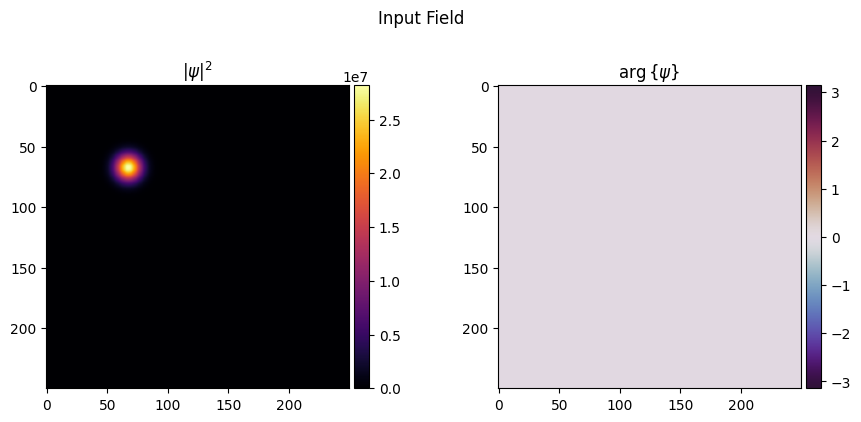

In [ ]:
# Make the input fields
input_field = Field(gaussian(shape, waist_radius, offset=(3.8*waist_radius, 3.8*waist_radius)), z=0).to(device)
input_field.visualize(title="Input Field")

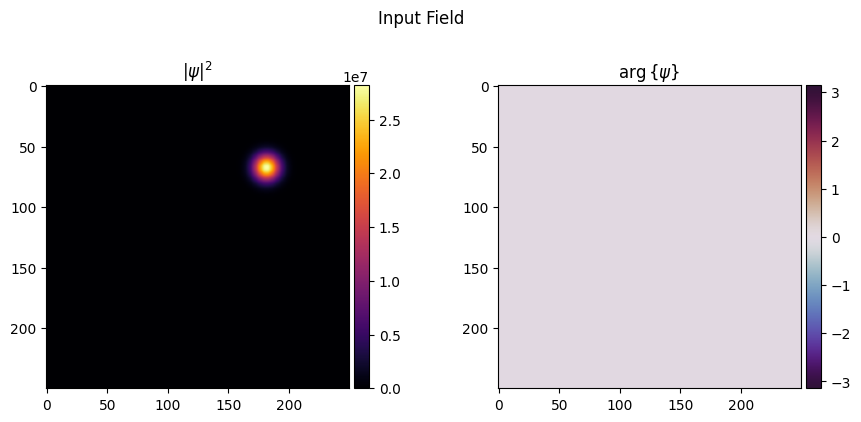

In [22]:
input_field2 = Field(gaussian(shape, waist_radius, offset=(3.8*waist_radius, -3.8*waist_radius)), z=0).to(device)
input_field2.visualize(title="Input Field")

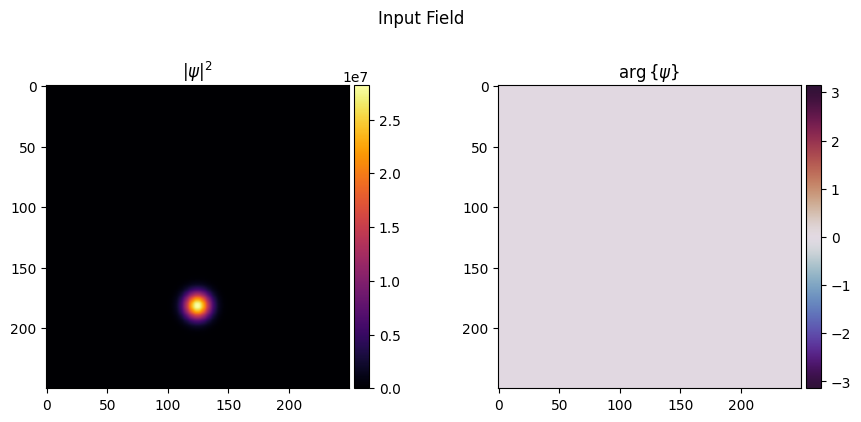

In [24]:
input_field3 = Field(gaussian(shape, waist_radius, offset=(-3.8*waist_radius, 0*waist_radius)), z=0).to(device)
input_field3.visualize(title="Input Field")

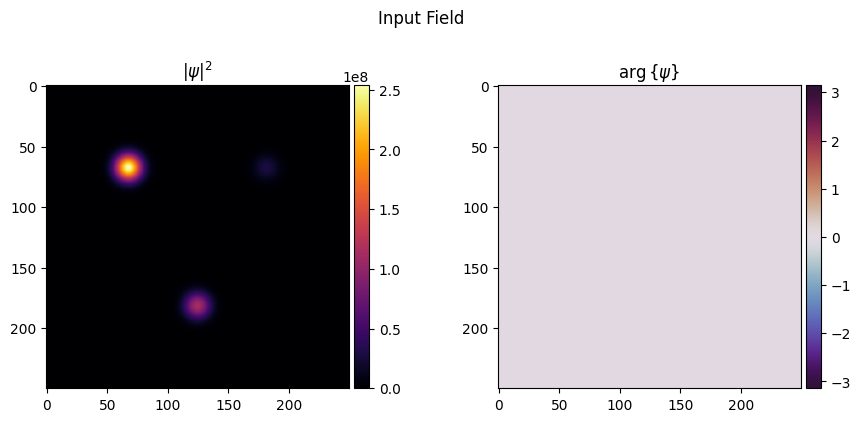

In [30]:
input_field_4 = Field(3*gaussian(shape, waist_radius, offset=(3.8*waist_radius, 3.8*waist_radius))
                      + gaussian(shape, waist_radius, offset=(3.8*waist_radius, -3.8*waist_radius))
                      + 2*gaussian(shape, waist_radius, offset=(-3.8*waist_radius, 0*waist_radius)), z=0).to(device)
input_field_4.visualize(title="Input Field")

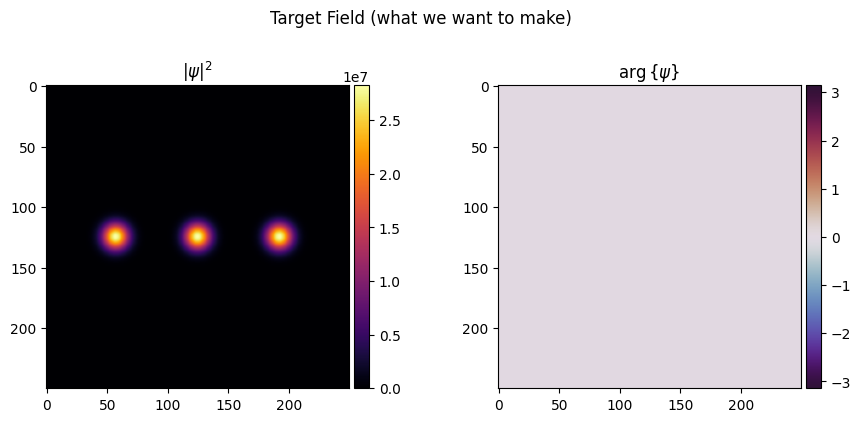

In [17]:
target_field_data = (gaussian(shape, waist_radius, offset=(0*waist_radius, 4.5*waist_radius))
                     + gaussian(shape, waist_radius, offset=(0*waist_radius, 0*waist_radius))
                     + gaussian(shape, waist_radius, offset=(0*waist_radius, -4.5*waist_radius)))

# Convert the data into the Field class
target_field = Field(target_field_data, z=0.6).to(device)
target_field.visualize(title="Target Field (what we want to make)")

In [18]:
# Create a system (sequence of elements) that the field will propagate through
system = System(PhaseModulator(Param(torch.zeros(250,250)), z=0.0),
                PhaseModulator(Param(torch.zeros(250,250)), z=0.2),
                PhaseModulator(Param(torch.zeros(250,250)), z=0.4)).to(device)

In [19]:
# Train the parameters in the PhaseModulators to give an output close to the target.
optimiser = torch.optim.Adam(system.parameters(), lr=0.1)
losses = [] # Create a list to graph later

for iteration in range(1,401):
    optimiser.zero_grad() # Type of optimisation
    output_field = system.measure_at_z(input_field, 0.6) # Measure input field after it propagates through the system to z=0.6

    # Calculate losses
    loss = 1 - output_field.inner(target_field).abs().square()
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

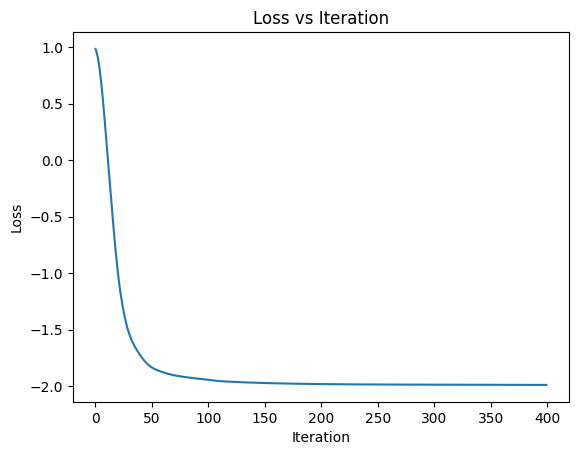

In [20]:
# Plot losses data
plt.plot(losses)

# Make it look nice
plt.title("Loss vs Iteration")
plt.xlabel("Iteration"), plt.ylabel("Loss")
#plt.yscale("log") # Logarithmic scale
plt.show()

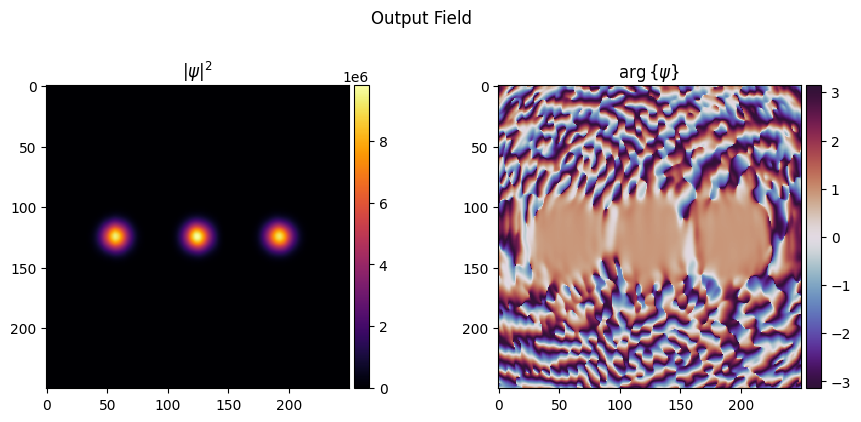

In [21]:
output_field = system.measure_at_z(input_field, z=0.6)
output_field.visualize(title="Output Field")